In [1]:
!pip install jupyter_black --quiet
%load_ext jupyter_black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.1 MB/s eta 0:00:00


In [2]:
!pip install gdown torch torchvision matplotlib tqdm torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 53.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
import os
import gdown
import zipfile
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import transforms
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torchmetrics.image.fid import FrechetInceptionDistance

# Загрузка данных

Скачиваем CelebA (~1.4 ГБ)...


Downloading...
From (original): https://drive.google.com/uc?id=1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW
From (redirected): https://drive.google.com/uc?id=1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW&confirm=t&uuid=c1cdadef-f331-4e02-9776-3c4e55ca0a8e
To: /content/celeba.zip
100%|██████████| 1.43G/1.43G [00:20<00:00, 70.3MB/s]


Распаковываем архив...
Готово!


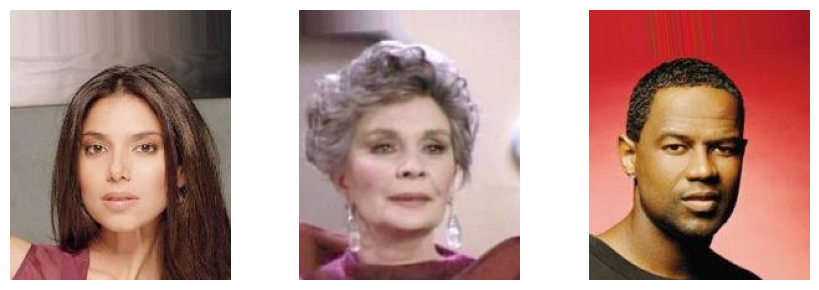

In [4]:
# 1) Скачивание и распаковка CelebA
TARGET_DIR = "."
ARCHIVE_NAME = "celeba.zip"
GDRIVE_URL = "https://drive.google.com/uc?id=1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW"
archive_path = os.path.join(TARGET_DIR, ARCHIVE_NAME)

if not os.path.exists(archive_path):
    print("Скачиваем CelebA (~1.4 ГБ)...")
    gdown.download(GDRIVE_URL, output=archive_path, quiet=False)
    print("Распаковываем архив...")
    with zipfile.ZipFile(archive_path, "r") as zf:
        zf.extractall(TARGET_DIR)
    print("Готово!")
else:
    print("Архив найден, скачивание пропущено.")

# Проверка размера (должен быть > 1 ГБ)
filesize = os.path.getsize(archive_path)
assert (
    filesize > 2**30
), f"{filesize/2**30:.2f} ГБ — размер меньше ожидаемого, проверьте скачивание"

plt.figure(figsize=(9, 3))
for i, img_name in enumerate(["100019.jpg", "000084.jpg", "148483.jpg"], 1):
    plt.subplot(1, 3, i)
    img = plt.imread(os.path.join("celeba", "celeba", "img_align_celeba", img_name))
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Подготовка данных

In [5]:
# 2) Определяем кастомный кроп (чтобы получить квадратное лицо)
from PIL import Image


class CropCelebASquare:
    """Обрезаем центральную часть лицевой области (148×148 px)."""

    def __call__(self, img: Image.Image) -> Image.Image:
        # исходник 178×218: хотим 148×148 область
        return img.crop((15, 40, 178 - 15, 218 - 30))

    def __repr__(self):
        return self.__class__.__name__ + "()"


# 3) Трансформы: квадратный кроп → Resize → Flip → ToTensor → Normalize
transform = transforms.Compose(
    [
        CropCelebASquare(),  # обрезаем лицо
        transforms.Resize(128),  # размер 128×128
        transforms.RandomHorizontalFlip(),  # аугментация
        transforms.ToTensor(),  # [0..1]
        transforms.Normalize(  # [–1..+1]
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
        ),
    ]
)

In [6]:
# 4) Создаем датасеты и даталоадеры
data_root = os.path.join(TARGET_DIR, "celeba")
train_ds = torchvision.datasets.CelebA(
    root=data_root,
    split="train",
    download=False,
    transform=transform,
)
val_ds = torchvision.datasets.CelebA(
    root=data_root,
    split="valid",
    download=False,
    transform=transform,
)

BATCH_SIZE = 64
NUM_WORKERS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

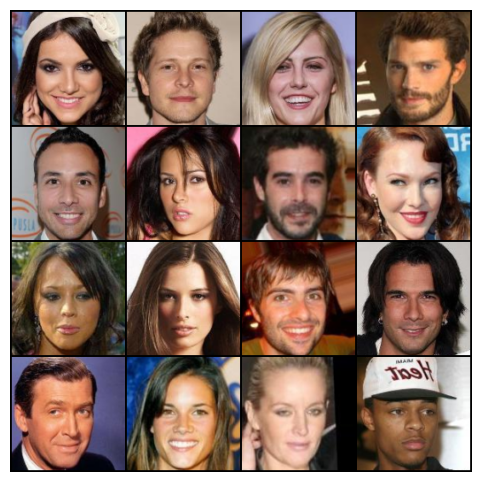

In [7]:
# 5) Визуальная проверка
batch = next(iter(train_loader))[0].to(device)
grid = torchvision.utils.make_grid(
    batch[:16], nrow=4, normalize=True, value_range=(-1, 1)
)
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.show()

# Архитектурные блоки

In [8]:
class CSPup(nn.Module):
    """
    Блок CSPup:
    - Ветвь A: ConvTranspose2d(in->mid, 4,2,1)
    - Ветвь B: Conv2d(in->mid,1,1)+ReLU -> ConvTranspose2d(mid->mid,4,2,1)+ReLU -> Conv2d(mid->mid,3,1,1)+ReLU x2
    Суммируем выходы обеих ветвей.
    """

    def __init__(self, in_channels: int, mid_channels: int):
        super(CSPup, self).__init__()
        self.branchA = nn.ConvTranspose2d(
            in_channels, mid_channels, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.branchB = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                mid_channels,
                mid_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.branchA(x) + self.branchB(x)


class Generator(nn.Module):
    """
    Генератор:
    z (100,1,1) -> 4x4x1024 -> CSPup -> 8x8x512 ->
      deconv 512->256 -> 16x16x256 ->
      deconv 256->128 -> 32x32x128 ->
      deconv 128->64  -> 64x64x64 ->
      deconv 64->3    -> 128x128x3 + Tanh
    """

    def __init__(self, z_dim: int = 100):
        super(Generator, self).__init__()
        self.proj = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
        )
        self.cspup = CSPup(1024, 512)
        self.ups = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = self.proj(z)
        x = self.cspup(x)
        x = self.ups(x)
        return x


class Discriminator(nn.Module):
    """
    Дискриминатор:
    (3x128x128) ->
      64x64 -> 128x32 -> 256x16 -> 512x8 -> 1024x4 -> 1x1
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 128 -> 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 -> 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 32 -> 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 16 -> 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 8 -> 4
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # 4 -> 1
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)


# --- Инициализация весов ---
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)


# --- Тренировочный цикл ---
def train_gan(G, D, loader: DataLoader, device, epochs=1, lr=2e-4, beta1=0.5):
    criterion = nn.BCELoss()
    G.apply(weights_init)
    D.apply(weights_init)
    optD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
    optG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

    for epoch in range(epochs):
        for i, (real, _) in enumerate(loader):
            real = real.to(device)
            bsz = real.size(0)
            real_labels = torch.ones(bsz, device=device)
            fake_labels = torch.zeros(bsz, device=device)

            # Обновляем D
            D.zero_grad()
            out_real = D(real).view(-1)
            lossD_real = criterion(out_real, real_labels)
            z = torch.randn(bsz, 100, 1, 1, device=device)
            fake = G(z)
            out_fake = D(fake.detach()).view(-1)
            lossD_fake = criterion(out_fake, fake_labels)
            lossD = lossD_real + lossD_fake
            lossD.backward()
            optD.step()

            # Обновляем G
            G.zero_grad()
            out_fake2 = D(fake).view(-1)
            lossG = criterion(out_fake2, real_labels)
            lossG.backward()
            optG.step()

            if i % 100 == 0:
                print(
                    f"Epoch[{epoch}/{epochs}] Iter[{i}/{len(loader)}] "
                    f"LossD: {lossD.item():.4f} LossG: {lossG.item():.4f}"
                )
        # Визуализация после эпохи
        with torch.no_grad():
            z = torch.randn(16, 100, 1, 1, device=device)
            samples = G(z).cpu()
            grid = torchvision.utils.make_grid(
                samples, nrow=4, normalize=True, value_range=(-1, 1)
            )
            plt.figure(figsize=(4, 4))
            plt.axis("off")
            plt.imshow(grid.permute(1, 2, 0))
            plt.show()

[PASS] CSPup
[PASS] Generator
[PASS] Discriminator
Epoch[0/1] Iter[0/4] LossD: 0.9964 LossG: 36.8853


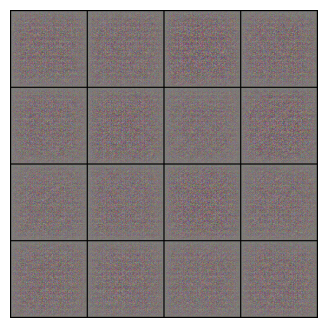

[PASS] Train loop executed


In [9]:
# тест CSPup
b, ic, oc = 2, 1024, 512
x = torch.randn(b, ic, 4, 4)
assert CSPup(ic, oc)(x).shape == (b, oc, 8, 8)
print("[PASS] CSPup")

# тест Generator
z = torch.randn(b, 100, 1, 1)
g = Generator(100)
f = g(z)
assert f.shape == (b, 3, 128, 128)
print("[PASS] Generator")

# тест Discriminator
d = Discriminator()
s = d(f)
assert s.shape == (b, 1, 1, 1)
print("[PASS] Discriminator")

# Тест train loop на случайных данных
device = torch.device("cpu")
bs_test = 2
random_data = [(torch.randn(3, 128, 128), 0) for _ in range(bs_test * 4)]
loader = DataLoader(random_data, batch_size=bs_test)
train_gan(g, d, loader, device, epochs=1)
print("[PASS] Train loop executed")

[PASS] Архитектуры OK
Epoch[0/5] Iter[0/2544] LossD: 2.1837 LossG: 16.0093
Epoch[0/5] Iter[100/2544] LossD: 0.0437 LossG: 51.2348
Epoch[0/5] Iter[200/2544] LossD: 0.0000 LossG: 49.8974
Epoch[0/5] Iter[300/2544] LossD: 0.0000 LossG: 48.8494
Epoch[0/5] Iter[400/2544] LossD: 0.0000 LossG: 48.8872
Epoch[0/5] Iter[500/2544] LossD: 0.0000 LossG: 48.7463
Epoch[0/5] Iter[600/2544] LossD: 0.0000 LossG: 48.7401
Epoch[0/5] Iter[700/2544] LossD: 0.0000 LossG: 48.1572
Epoch[0/5] Iter[800/2544] LossD: 0.0000 LossG: 48.5413
Epoch[0/5] Iter[900/2544] LossD: 0.0000 LossG: 48.1453
Epoch[0/5] Iter[1000/2544] LossD: 0.0000 LossG: 48.2885
Epoch[0/5] Iter[1100/2544] LossD: 0.0000 LossG: 48.2575
Epoch[0/5] Iter[1200/2544] LossD: 0.0000 LossG: 47.8798
Epoch[0/5] Iter[1300/2544] LossD: 0.0000 LossG: 45.9572
Epoch[0/5] Iter[1400/2544] LossD: 0.0000 LossG: 45.7927
Epoch[0/5] Iter[1500/2544] LossD: 0.0000 LossG: 45.8470
Epoch[0/5] Iter[1600/2544] LossD: 0.0000 LossG: 45.9792
Epoch[0/5] Iter[1700/2544] LossD: 0.00

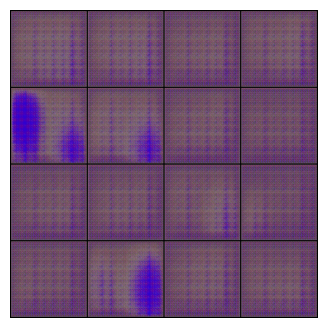

Epoch[1/5] Iter[0/2544] LossD: 0.1940 LossG: 6.8806
Epoch[1/5] Iter[100/2544] LossD: 0.0165 LossG: 5.7100
Epoch[1/5] Iter[200/2544] LossD: 0.0538 LossG: 4.0625
Epoch[1/5] Iter[300/2544] LossD: 0.7020 LossG: 7.0021
Epoch[1/5] Iter[400/2544] LossD: 2.3008 LossG: 4.7179
Epoch[1/5] Iter[500/2544] LossD: 0.8737 LossG: 2.6274
Epoch[1/5] Iter[600/2544] LossD: 0.8488 LossG: 2.2394
Epoch[1/5] Iter[700/2544] LossD: 1.4104 LossG: 2.8842
Epoch[1/5] Iter[800/2544] LossD: 1.2450 LossG: 2.2248
Epoch[1/5] Iter[900/2544] LossD: 1.7081 LossG: 1.7810
Epoch[1/5] Iter[1000/2544] LossD: 1.0709 LossG: 2.9809
Epoch[1/5] Iter[1100/2544] LossD: 0.9791 LossG: 5.9034
Epoch[1/5] Iter[1200/2544] LossD: 1.6420 LossG: 2.9437
Epoch[1/5] Iter[1300/2544] LossD: 1.2679 LossG: 3.9665
Epoch[1/5] Iter[1400/2544] LossD: 1.0812 LossG: 2.7985
Epoch[1/5] Iter[1500/2544] LossD: 1.2834 LossG: 1.6805
Epoch[1/5] Iter[1600/2544] LossD: 0.9829 LossG: 2.2772
Epoch[1/5] Iter[1700/2544] LossD: 1.1603 LossG: 2.9632
Epoch[1/5] Iter[1800/2

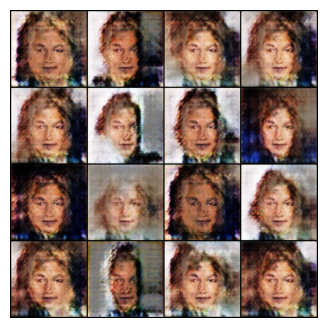

Epoch[2/5] Iter[0/2544] LossD: 2.1255 LossG: 3.8769
Epoch[2/5] Iter[100/2544] LossD: 1.3446 LossG: 3.2548
Epoch[2/5] Iter[200/2544] LossD: 0.9876 LossG: 2.1532
Epoch[2/5] Iter[300/2544] LossD: 1.1373 LossG: 1.8396
Epoch[2/5] Iter[400/2544] LossD: 1.1718 LossG: 2.0056
Epoch[2/5] Iter[500/2544] LossD: 1.2990 LossG: 4.1102
Epoch[2/5] Iter[600/2544] LossD: 0.9010 LossG: 4.4802
Epoch[2/5] Iter[700/2544] LossD: 0.6660 LossG: 2.5118
Epoch[2/5] Iter[800/2544] LossD: 0.7478 LossG: 3.1112
Epoch[2/5] Iter[900/2544] LossD: 0.8310 LossG: 3.0552
Epoch[2/5] Iter[1000/2544] LossD: 1.1425 LossG: 2.3256
Epoch[2/5] Iter[1100/2544] LossD: 0.8717 LossG: 5.0838
Epoch[2/5] Iter[1200/2544] LossD: 0.8783 LossG: 3.8802
Epoch[2/5] Iter[1300/2544] LossD: 0.8317 LossG: 2.2124
Epoch[2/5] Iter[1400/2544] LossD: 0.6100 LossG: 2.4147
Epoch[2/5] Iter[1500/2544] LossD: 0.9029 LossG: 2.6407
Epoch[2/5] Iter[1600/2544] LossD: 0.7379 LossG: 1.6235
Epoch[2/5] Iter[1700/2544] LossD: 0.8240 LossG: 4.1818
Epoch[2/5] Iter[1800/2

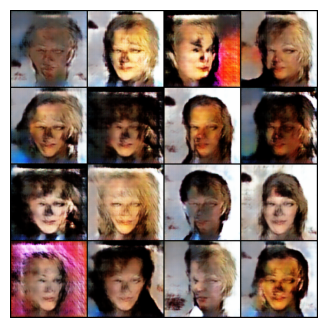

Epoch[3/5] Iter[0/2544] LossD: 0.7212 LossG: 4.3599
Epoch[3/5] Iter[100/2544] LossD: 0.7259 LossG: 3.7982
Epoch[3/5] Iter[200/2544] LossD: 1.1104 LossG: 2.8591
Epoch[3/5] Iter[300/2544] LossD: 0.9795 LossG: 3.9771
Epoch[3/5] Iter[400/2544] LossD: 1.0005 LossG: 2.6780
Epoch[3/5] Iter[500/2544] LossD: 0.9778 LossG: 2.7489
Epoch[3/5] Iter[600/2544] LossD: 1.0012 LossG: 3.2162
Epoch[3/5] Iter[700/2544] LossD: 0.5729 LossG: 2.1062
Epoch[3/5] Iter[800/2544] LossD: 0.9216 LossG: 1.9408
Epoch[3/5] Iter[900/2544] LossD: 0.9497 LossG: 3.8721
Epoch[3/5] Iter[1000/2544] LossD: 0.7598 LossG: 3.7657
Epoch[3/5] Iter[1100/2544] LossD: 0.7515 LossG: 2.6392
Epoch[3/5] Iter[1200/2544] LossD: 0.9006 LossG: 2.2406
Epoch[3/5] Iter[1300/2544] LossD: 0.8557 LossG: 1.7745
Epoch[3/5] Iter[1400/2544] LossD: 0.9079 LossG: 4.0245
Epoch[3/5] Iter[1500/2544] LossD: 1.1071 LossG: 1.9843
Epoch[3/5] Iter[1600/2544] LossD: 0.7179 LossG: 3.2616
Epoch[3/5] Iter[1700/2544] LossD: 1.1324 LossG: 4.5340
Epoch[3/5] Iter[1800/2

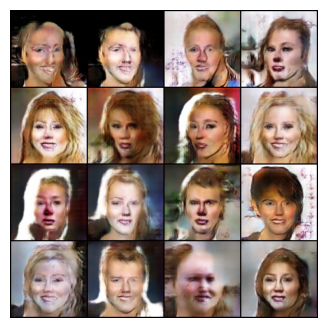

Epoch[4/5] Iter[0/2544] LossD: 1.3342 LossG: 6.0216
Epoch[4/5] Iter[100/2544] LossD: 0.7491 LossG: 2.2398
Epoch[4/5] Iter[200/2544] LossD: 0.7747 LossG: 2.3468
Epoch[4/5] Iter[300/2544] LossD: 1.4923 LossG: 1.5440
Epoch[4/5] Iter[400/2544] LossD: 0.5822 LossG: 3.2036
Epoch[4/5] Iter[500/2544] LossD: 0.9439 LossG: 4.2020
Epoch[4/5] Iter[600/2544] LossD: 1.5283 LossG: 5.2884
Epoch[4/5] Iter[700/2544] LossD: 0.8421 LossG: 2.7908
Epoch[4/5] Iter[800/2544] LossD: 0.7502 LossG: 3.4362
Epoch[4/5] Iter[900/2544] LossD: 1.0207 LossG: 2.7261
Epoch[4/5] Iter[1000/2544] LossD: 0.9209 LossG: 2.0008
Epoch[4/5] Iter[1100/2544] LossD: 0.7335 LossG: 2.9041
Epoch[4/5] Iter[1200/2544] LossD: 0.9427 LossG: 3.2950
Epoch[4/5] Iter[1300/2544] LossD: 1.0690 LossG: 3.9653
Epoch[4/5] Iter[1400/2544] LossD: 1.7463 LossG: 1.1535
Epoch[4/5] Iter[1500/2544] LossD: 0.5924 LossG: 2.7863
Epoch[4/5] Iter[1600/2544] LossD: 0.5161 LossG: 2.5561
Epoch[4/5] Iter[1700/2544] LossD: 0.5472 LossG: 1.7252
Epoch[4/5] Iter[1800/2

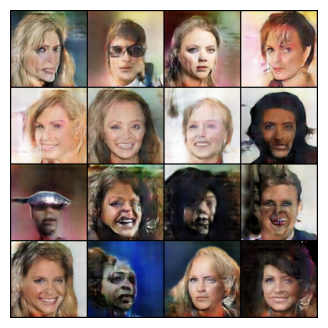

[PASS] Training on CelebA completed


In [ ]:
print("[PASS] Архитектуры OK")

G = Generator(100).to(device)
D = Discriminator().to(device)
train_gan(G, D, train_loader, device, epochs=5)
print("[PASS] Training on CelebA completed")

- На 5-й эпохе уже можно заметить «фейсподобные» структуры: форма головы, «глаза», «носы» и даже иногда цвета волос.
- Результат на 5 эпохах — ожидаемо «грубый», но в правильном направлении.

In [ ]:
# Инициализация весов
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)


# Сохранение и загрузка чекпоинтов
def save_checkpoint(epoch, G, D, optG, optD, filename="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "G_state_dict": G.state_dict(),
        "D_state_dict": D.state_dict(),
        "optG_state_dict": optG.state_dict(),
        "optD_state_dict": optD.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Чекпоинт сохранен на эпохе {epoch}")


def load_checkpoint(G, D, optG, optD, filename="checkpoint.pth"):
    checkpoint = torch.load(filename)
    epoch = checkpoint["epoch"]
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optG.load_state_dict(checkpoint["optG_state_dict"])
    optD.load_state_dict(checkpoint["optD_state_dict"])
    print(f"Чекпоинт загружен с эпохи {epoch}")
    return epoch


def train_gan(
    G, D, loader: DataLoader, device, epochs=1, lr=2e-4, beta1=0.5, start_epoch=0
):
    criterion = nn.BCELoss()
    G.apply(weights_init)
    D.apply(weights_init)
    optD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
    optG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

    for epoch in range(start_epoch, epochs):
        with tqdm(
            enumerate(loader), total=len(loader), desc=f"Эпоха {epoch}/{epochs}"
        ) as pbar:
            for i, (real, _) in pbar:
                real = real.to(device)
                bsz = real.size(0)
                real_labels = torch.ones(bsz, device=device)
                fake_labels = torch.zeros(bsz, device=device)

                D.zero_grad()
                out_real = D(real).view(-1)
                lossD_real = criterion(out_real, real_labels)
                z = torch.randn(bsz, 100, 1, 1, device=device)
                fake = G(z)
                out_fake = D(fake.detach()).view(-1)
                lossD_fake = criterion(out_fake, fake_labels)
                lossD = lossD_real + lossD_fake
                lossD.backward()
                optD.step()

                G.zero_grad()
                out_fake2 = D(fake).view(-1)
                lossG = criterion(out_fake2, real_labels)
                lossG.backward()
                optG.step()

                pbar.set_postfix(lossD=lossD.item(), lossG=lossG.item())

        with torch.no_grad():
            z = torch.randn(16, 100, 1, 1, device=device)
            samples = G(z).cpu()
            grid = torchvision.utils.make_grid(
                samples, nrow=4, normalize=True, value_range=(-1, 1)
            )
            plt.figure(figsize=(4, 4))
            plt.axis("off")
            plt.imshow(grid.permute(1, 2, 0))
            plt.show()

        save_checkpoint(epoch, G, D, optG, optD)

        validate(G, D, val_loader, device)


def validate(G, D, val_loader, device):
    G.eval()
    D.eval()

    total_fid = 0.0
    with torch.no_grad():
        for real, _ in val_loader:
            real = real.to(device)
            z = torch.randn(real.size(0), 100, 1, 1, device=device)
            fake = G(z)

            # Вычисляем метрики качества изображений
            fid = FrechetInceptionDistance()
            fid.update(real, real_labels=None)
            fid.update(fake, fake_labels=None)
            total_fid += fid.compute()

    print(f"Средний FID на валидации: {total_fid / len(val_loader)}")
    G.train()  # Возвращаем генератор в режим тренировки
    D.train()  # Возвращаем дискриминатор в режим тренировки


# Инициализация генератора и дискриминатора
G = Generator(100).to(device)
D = Discriminator().to(device)

start_epoch = 0
try:
    start_epoch = load_checkpoint(
        G, D, optim.Adam(D.parameters(), lr=2e-4), optim.Adam(G.parameters(), lr=2e-4)
    )
except FileNotFoundError:
    print("Чекпоинты не найдены, обучение начнется с нуля.")

train_gan(G, D, train_loader, device, epochs=10, start_epoch=start_epoch)

Чекпоинты не найдены, обучение начнется с нуля.


Эпоха 0/10:   0%|          | 0/2544 [00:00<?, ?it/s]

In [ ]:
from IPython.display import clear_output
clear_output(wait=True)

: 